In [1]:
from selenium import webdriver
import pandas as pd
# import matplotlib
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import statistics
import resources # custom libraries
import numpy as np
from tensorflow import keras
import tensorflow as tf
from datetime import datetime

## Scrapping the data
- Entering url and stracting data as a Pandas df
- After scrapping the data, df will be stored as CSV file
- If data has been already scrapped, data is stracted from CSV

In [2]:
training = True

if training:
    today = str(datetime.today().strftime('%d-%m'))
    # Getting data
    df = resources.data_scraper.scrape()
    # Casting columns
    df[df.columns[2]] = df[df.columns[2]].astype(np.int64)
    df[df.columns[3]] = df[df.columns[3]].astype(np.int64)
    # Adding total_score column
    df["TotalScore"] = df[df.columns[2]] + df[df.columns[3]]
    # Store CSV
    df.to_csv('data/{}.csv'.format(today), encoding='utf-8', index=False)
else:
    today = '07-05'
    df = pd.read_csv('data/{}.csv'.format(today))

Discarding following match Toronto Raptors vs Washington Wizards
Discarding following match Cleveland Cavaliers vs Phoenix Suns
Discarding following match San Antonio Spurs vs Philadelphia 76ers
Discarding following match Minnesota Timberwolves vs New Orleans Pelicans
Discarding following match Boston Celtics vs San Antonio Spurs
Discarding following match Washington Wizards vs San Antonio Spurs
Discarding following match New York Knicks vs Atlanta Hawks
Discarding following match Denver Nuggets vs Memphis Grizzlies
Discarding following match Milwaukee Bucks vs Phoenix Suns
Discarding following match New York Knicks vs New Orleans Pelicans
Discarding following match Los Angeles Lakers vs Utah Jazz
Discarding following match Washington Wizards vs New Orleans Pelicans
Discarding following match Boston Celtics vs Minnesota Timberwolves
Discarding following match New York Knicks vs Memphis Grizzlies
Discarding following match Phoenix Suns vs Utah Jazz
Discarding following match San Antonio

In [3]:
df.head()

,HomeTeam,AwayTeam,ScoreHome,ScoreAway,TotalScore
0,Golden State Warriors,Oklahoma City Thunder,118,97,215
1,Los Angeles Clippers,Los Angeles Lakers,118,94,212
2,Detroit Pistons,Memphis Grizzlies,111,97,208
3,Indiana Pacers,Atlanta Hawks,133,126,259
4,Dallas Mavericks,Brooklyn Nets,113,109,222


#### Heatmap

In [65]:
# resources.graph.heatmap(df, f_size=10, cmap="afmhot_r",vmin=150, vmax=250)

### Frecuency histogram
- To know how many divisions or 'bins' should be done in the histogram, we must use Sturges law

$$ c = 1 + \dfrac{log(M)}{log(2)}$$

In [5]:
# resources.graph.frecuency_histogram(df)


#### Boxplot

In [6]:
# plt.boxplot(df['TotalScore'])
# plt.title("Total score distribution")

#### Normal dfistribution

In [7]:
# resources.graph.normal_distribution(df, 'Atlanta Hawks')

## Data analysis
- Analysing data
- Store results in a new df

In [8]:
stats_df = resources.nba_stats.stats(df)
stats_df.head()

,team,mean,P25,P75,factorDown,factorUp,WfactorDown,WfactorUp
0,Golden State Warriors,225.449275,214.0,234.0,1.449275,13.043478,2.876025,93.051634
1,Los Angeles Clippers,221.742857,210.0,234.0,8.571429,8.571429,58.281345,53.724774
2,Detroit Pistons,214.701493,201.0,224.5,14.925373,5.970149,111.063811,32.789787
3,Indiana Pacers,228.285714,214.0,243.0,9.523810,20.634921,43.107490,201.228233
4,Dallas Mavericks,221.955224,210.0,236.0,13.432836,8.955224,89.239944,111.804113


Correlation analysis

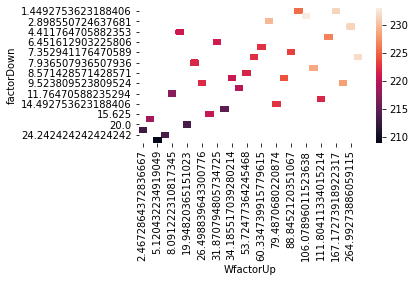

In [67]:
x_col = "factorDown"
y_col = "WfactorUp"
z_col = "mean"

# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
sub_df = stats_df.loc[:, [x_col, y_col, z_col]]
# sub_df.drop_duplicates(subset=x_col, inplace=True)
# sub_df.drop_duplicates(subset=y_col, inplace=True)
pivoted = sub_df.pivot(x_col, y_col, z_col)

ax = sns.heatmap(pivoted)

plt.tight_layout()
plt.show()

## Training model

In [150]:
# Extract X, deleting non desired attributes
def replace_teams(df, stats_df):
    merged = pd.merge(left=df.iloc[:, :2], right=stats_df, how='inner',
                     left_on='HomeTeam', right_on='team')

    merged = pd.merge(left=merged, right=stats_df, how='inner',
                     left_on='AwayTeam', right_on='team')
#     print(merged.head())
    X = merged.iloc[:, np.r_[3:10, 11:18]]
#     print(X.head())

#     X = X.iloc[:, [1,6,  9,12]]
    return X

In [151]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
min_score_value = df['TotalScore'].min()
max_score_value = df['TotalScore'].max()
range_scores = [x for x in range(min_score_value, max_score_value+1)]
range_scores = np.array(range_scores)
range_scores = np.expand_dims(range_scores, axis=1)

ohe.fit(range_scores)

X = replace_teams(df, stats_df)
# print(X)

# y = pd.get_dummies(df['TotalScore'], prefix='score')
y = ohe.transform(df[['TotalScore']]).toarray()

In [152]:
from sklearn.preprocessing import MinMaxScaler, normalize
x_scaler = MinMaxScaler().fit(X)

if training:# Normalize data
    X_norm = x_scaler.transform(X)

In [153]:
if training: # Create training and validations sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=42)

In [1]:
if training: # Train the model 
    # Create you neural net
    from keras.models import Sequential
    from keras.layers import Dense
    
    # Model parameters
    input_dim = X.shape[1]
    out_size = y.shape[1]
    
    # Model creation
    model = Sequential()
    model.add(Dense(200, input_dim=input_dim, activation='relu')) # 14
    model.add(Dense(160, activation='selu'))
    model.add(Dense(150, activation='selu'))
    model.add(Dense(120, activation='relu'))
    model.add(Dense(out_size, activation='sigmoid'))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
    
    # Model training
    model.fit(X_norm, y, epochs=200, batch_size=10, shuffle=True, verbose=2)
    
    # Store model
    model.save('./models/OHE/{}'.format(today))
else: # Get stored model
    model = keras.models.load_model('./models/OHE'.format(today))

NameError: name 'training' is not defined

Analysing model

In [158]:
if training:
    predictions = model.predict(X_test)

    decoded_test = ohe.inverse_transform(y_test)
    decoded_prediction = ohe.inverse_transform(predictions)

    data = np.concatenate((decoded_test, decoded_prediction), axis=1)

    comparation = pd.DataFrame(data=data, columns=["Train", "Prediction"])
    comparation['Error'] = abs(comparation['Train'] - comparation['Prediction'])
    comparation = comparation.astype('int32')

    print('The maximum error:', comparation['Error'].max())
    print('The average error:', comparation['Error'].mean())
    print('The dispersion of data:', comparation['Error'].std())

    comparation.head(3)
    
    # Epochs = 200
    # Maximum error = 50
    # Average error = 5
    # Dispersion = 11

The maximum error: 58
The average error: 4.905723905723906
The dispersion of data: 11.28131681223912


## Predicting data

In [159]:
future_games = [
    ['NO', 'PHI', 227],
    ['BOS', 'CHI', 224],
    ['HOU', 'MIL', 232],
    ['MIN', 'MIA', 227],
    ['ORL', 'CHA', 215],
    ['CLE', 'DAL', 219],
    ['DEN', 'UTA', 215],
    ['LAL', 'POR', 222],
    ['NY', 'PHX', 217],
    ['SA', 'SAC', 223],
]

new_games = pd.DataFrame(columns = ['HomeTeam', 'AwayTeam', 'BetScore'])
               
for game in future_games:
    home_team = resources.teams.conversion_dict[game[0]]
    away_team = resources.teams.conversion_dict[game[1]]
    game = [home_team, away_team, game[2]]
    resources.df_helper.append_row(new_games, game)
    
today_games = replace_teams(new_games, stats_df)
today_games_norm = x_scaler.transform(today_games)

predictions = model.predict(today_games_norm)
decoded_predictions = ohe.inverse_transform(predictions)

new_games['Predictions'] = decoded_predictions
new_games['Confidence'] = abs(new_games['BetScore'] - new_games['Predictions'])

new_games

,HomeTeam,AwayTeam,BetScore,Predictions,Confidence
0,New Orleans Pelicans,Philadelphia 76ers,227,217,10
1,Boston Celtics,Chicago Bulls,224,216,8
2,Houston Rockets,Milwaukee Bucks,232,217,15
3,Minnesota Timberwolves,Miami Heat,227,220,7
4,Orlando Magic,Charlotte Hornets,215,246,31
5,Cleveland Cavaliers,Dallas Mavericks,219,220,1
6,Denver Nuggets,Utah Jazz,215,209,6
7,Los Angeles Lakers,Portland Trail Blazers,222,252,30
8,New York Knicks,Phoenix Suns,217,233,16
9,San Antonio Spurs,Sacramento Kings,223,258,35
